In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import torch
import sys
import time
from models import UNet
from dataloader import get_dataloaders

In [2]:
model_list = ["unet_d3_out1_gpu_L1_traced.pt","unet_d4_out1_gpu_L1_traced.pt","unet_d5_out1_gpu_L1_traced.pt","unet_d6_out1_gpu_L1_traced.pt","unet_d7_out1_gpu_L1_traced.pt"]

In [4]:
for i in range(5):
    Depth = i + 3
    print(f"UNet Depth: {Depth}")
    
    ## CUDA
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("=== Result ===")
    print(f"Using device: {device}")

    timings = {}
    in_len = 5
    out_len = 1

    # Data preparation
    torch.cuda.synchronize()
    data_prep_start = time.time()
    test_loader, _ = get_dataloaders(1,
                                in_len=in_len,
                                out_len=out_len,
                                )

    test_input, test_target = next(iter(test_loader))
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    torch.cuda.synchronize()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start

    # Model load
    torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        model = torch.jit.load('./checkpoint/'+model_list[i], map_location="cuda")
        model.eval()
        torch.cuda.synchronize() 
        model_prep_end = time.time()
        timings['model_load'] = model_prep_end - start_time

    # Warm up
    with torch.no_grad():
        for k in range(10):
            _ = model(test_input)
    
    # Inference
    num_runs = 100 
    inference_times = []

    for j in range(num_runs):
        torch.cuda.synchronize()
        start_inference = time.time()
    
        with torch.no_grad():
            test_output = model(test_input)
    
        torch.cuda.synchronize()
        end_inference = time.time()
        inference_times.append(end_inference - start_inference)

    print(inference_times)
    avg_inference = sum(inference_times) / num_runs
    std_inference = (sum((x - avg_inference) ** 2 for x in inference_times) / num_runs) ** 0.5
    timings['avg_inference'] = avg_inference
    timings['std_inference'] = std_inference

    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")
    print(f"Model load time: {timings['model_load']:.6f} sec")
    print(f"Average inference ({num_runs} runs): {avg_inference:.6f} sec")

    batch_size = test_input.size(0)
    throughput = batch_size / avg_inference
    print(f"Throughput: {throughput:.2f} samples/sec")

    ## CPU
    device = torch.device('cpu')
    print("=== Result ===")
    print(f"Using device: {device}")

    timings = {}
    in_len = 5
    out_len = 1

    # Data preparation
    data_prep_start = time.time()
    test_loader, _ = get_dataloaders(1,
                                in_len=in_len,
                                out_len=out_len,
                                )

    test_input, test_target = next(iter(test_loader))
    test_input, test_target = test_input.to(device), test_target.to(device).float()
    data_prep_end = time.time()
    timings['data_preparation'] = data_prep_end - data_prep_start

    # Model load

    start_time = time.time()
    with torch.no_grad():
        model = torch.jit.load('./checkpoint/'+model_list[i], map_location="cpu")
        model.eval()
        model_prep_end = time.time()
        timings['model_load'] = model_prep_end - start_time
        
    # Warm up
    with torch.no_grad():
        for k in range(10):
            _ = model(test_input)

    # Inference
    num_runs = 100 
    inference_times = []

    for j in range(num_runs):
        start_inference = time.time()
    
        with torch.no_grad():
            test_output = model(test_input)
    
        end_inference = time.time()
        inference_times.append(end_inference - start_inference)

    print(inference_times)
    avg_inference = sum(inference_times) / num_runs
    std_inference = (sum((x - avg_inference) ** 2 for x in inference_times) / num_runs) ** 0.5
    timings['avg_inference'] = avg_inference
    timings['std_inference'] = std_inference

    print(f"Data preparation time: {timings['data_preparation']:.6f} sec")
    print(f"Model load time: {timings['model_load']:.6f} sec")
    print(f"Average inference ({num_runs} runs): {avg_inference:.6f} sec")

    batch_size = test_input.size(0)
    throughput = batch_size / avg_inference
    print(f"Throughput: {throughput:.2f} samples/sec\n")

UNet Depth: 3
=== Result ===
Using device: cuda
[0.0012443065643310547, 0.0012087821960449219, 0.001222848892211914, 0.0012280941009521484, 0.001226663589477539, 0.0012216567993164062, 0.001222372055053711, 0.0012235641479492188, 0.0012197494506835938, 0.0012090206146240234, 0.0012180805206298828, 0.0012195110321044922, 0.0012221336364746094, 0.0012166500091552734, 0.001216888427734375, 0.0012216567993164062, 0.0012125968933105469, 0.0012149810791015625, 0.0012183189392089844, 0.001232147216796875, 0.0012218952178955078, 0.0012252330780029297, 0.0012145042419433594, 0.0012140274047851562, 0.0012211799621582031, 0.0012218952178955078, 0.0012230873107910156, 0.0012233257293701172, 0.0012209415435791016, 0.0012202262878417969, 0.0012118816375732422, 0.0012166500091552734, 0.0012226104736328125, 0.0012204647064208984, 0.0012273788452148438, 0.0012409687042236328, 0.0012350082397460938, 0.0012383460998535156, 0.0012423992156982422, 0.0012500286102294922, 0.0012364387512207031, 0.00124430656

In [7]:
%%bash
nvcc -c cuda_sync.c -o cuda_sync.o -I/user-environment/env/default/include

In [8]:
%%bash
export LD_LIBRARY_PATH=/users/class171/miniconda3/envs/weather-cnn/lib:/users/class171/FTorchbin/lib64:$LD_LIBRARY_PATH
for depth in d3 d4 d5 d6 d7; do
    echo "Running with depth: $depth"
    make run_infer_cuda MODEL=checkpoint/unet_${depth}_out1_gpu_L1_traced.pt DATADIR=data
done

Running with depth: d3
gfortran -I/users/class171/FTorchbin/include -I/users/class171/FTorchbin/include/ftorch -I/users/class171/Project/FTorch/build/modules -o infer_fortran_cuda.x infer_fortran_cuda.f90 cuda_sync.o -L/users/class171/FTorchbin/lib64 -L/user-environment/env/default/lib64 -lftorch -lcudart


f951: Warning: Nonexistent include directory '/users/class171/Project/FTorch/build/modules' [-Wmissing-include-dirs]


LD_LIBRARY_PATH=/user-environment/env/default/lib64:$LD_LIBRARY_PATH ./infer_fortran_cuda.x checkpoint/unet_d3_out1_gpu_L1_traced.pt data


/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   1.24024600E-03   1.21371797E-03   1.23195804E-03   1.21147803E-03   1.21803803E-03   1.21810299E-03   1.20939896E-03   1.21320598E-03   1.21375103E-03   1.21567002E-03   1.21832604E-03   1.21749402E-03   1.20863097E-03   1.22005399E-03   1.20312697E-03   1.21214997E-03   1.20805495E-03   1.20939896E-03   1.20491802E-03   1.21234194E-03   1.20863097E-03   1.21080596E-03   1.19919097E-03   1.20165397E-03   1.20997499E-03   1.20389403E-03   1.20952702E-03   1.21170201E-03   1.20568695E-03   1.20709406E-03   1.19992695E-03   1.20933505E-03   1.21167104E-03   1.20568695E-03   1.20539905E-03   1.21419795E-03   1.20239099E-03   1.20635796E-03   1.20872702E-03   1.20107795E-03   1.20248704E-03   1.20696600E-03   1.20943098E-03   1.20034197E-03   1.20613503E-03   1.21906202E-03   1.20792701E-03   1.21167104E-03   1.21298200E-03   1.21403905E-03   1.20901398E-03   1.20351103E-03   1.20478997E-03   1.21077395E-03   1.20341498E-03   1.21003797E-03   1.21394300E-03   1.21167104E-03   1.20315806E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   1.58890605E-03   1.55169005E-03   1.55233103E-03   1.55223405E-03   1.55533897E-03   1.56714604E-03   1.55005895E-03   1.55773899E-03   1.55239401E-03   1.56212295E-03   1.55297096E-03   1.54717895E-03   1.54961098E-03   1.55914598E-03   1.54644297E-03   1.54781900E-03   1.55034696E-03   1.55594596E-03   1.54609105E-03   1.55079504E-03   1.55639497E-03   1.55140297E-03   1.55511405E-03   1.55924296E-03   1.55108306E-03   1.55146699E-03   1.54429895E-03   1.55693898E-03   1.55645795E-03   1.55543501E-03   1.55677903E-03   1.56068197E-03   1.55364303E-03   1.55537098E-03   1.55597797E-03   1.54529104E-03   1.54897105E-03   1.54724298E-03   1.54135504E-03   1.55773805E-03   1.54269906E-03   1.54279498E-03   1.55402697E-03   1.53869996E-03   1.54932297E-03   1.54142000E-03   1.54423504E-03   1.54042698E-03   1.54154701E-03   1.54442701E-03   1.54637895E-03   1.54589897E-03   1.54919398E-03   1.54484296E-03   1.53924304E-03   1.54298695E-03   1.54916302E-03   1.54487498E-03   1.53645896E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.04092194E-03   2.00054003E-03   1.99628389E-03   1.99391507E-03   1.99644407E-03   1.99711602E-03   1.99769111E-03   1.99442799E-03   1.98863610E-03   2.00383505E-03   2.00149999E-03   1.99490809E-03   1.99471600E-03   1.99442799E-03   1.99142005E-03   1.99337211E-03   1.98597996E-03   1.98703608E-03   1.99497095E-03   1.99500308E-03   2.00338708E-03   1.99250807E-03   1.96822011E-03   1.96006102E-03   1.95721211E-03   1.95727707E-03   1.95753295E-03   1.95186900E-03   1.95522909E-03   1.95874902E-03   1.96546898E-03   1.95186900E-03   1.96054089E-03   1.95532502E-03   1.95762794E-03   1.96070108E-03   1.96204404E-03   1.95391709E-03   1.95519696E-03   1.96598005E-03   1.96153298E-03   1.96655700E-03   1.95874902E-03   1.95644493E-03   1.95570895E-03   1.95254094E-03   1.95474899E-03   1.95682910E-03   1.95503607E-03   1.96063705E-03   1.96799706E-03   1.96047709E-03   1.95775693E-03   1.95977301E-03   1.95097399E-03   1.95586798E-03   1.95692503E-03   1.96386897E-03   1.96089293E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   2.96348194E-03   2.92857201E-03   2.92345090E-03   2.92732404E-03   2.92946794E-03   2.92668398E-03   2.92761112E-03   2.93567590E-03   2.93365889E-03   2.93215504E-03   2.92991498E-03   2.92969192E-03   2.92175496E-03   2.92700389E-03   2.92473100E-03   2.93145189E-03   2.92146811E-03   2.92988401E-03   2.92713195E-03   2.91276397E-03   2.88998010E-03   2.89081293E-03   2.88396492E-03   2.88610905E-03   2.87855696E-03   2.87887710E-03   2.87196599E-03   2.88236490E-03   2.87878094E-03   2.86412612E-03   2.87548499E-03   2.88466900E-03   2.88550090E-03   2.87289289E-03   2.87174108E-03   2.86716595E-03   2.87647801E-03   2.88236607E-03   2.87378905E-03   2.89036497E-03   2.88271694E-03   2.87890900E-03   2.86390190E-03   2.88466900E-03   2.88450904E-03   2.86908611E-03   2.88390089E-03   2.86831707E-03   2.87132501E-03   2.88662105E-03   2.88588507E-03   2.87590106E-03   2.88550090E-03   2.88591697E-03   2.89506908E-03   2.92790006E-03   2.92741903E-03   2.91868392E-03   2.93285889E

/bin/sh: /users/class171/miniconda3/envs/weather-cnn/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


   5.82274422E-03   5.76031487E-03   5.76517917E-03   5.76370722E-03   5.77007420E-03   5.77788195E-03   5.76748187E-03   5.77301811E-03   5.77000994E-03   5.76466601E-03   5.76524204E-03   5.76901808E-03   5.77154709E-03   5.78616885E-03   5.78044122E-03   5.77765796E-03   5.77375386E-03   5.77449007E-03   5.78591414E-03   5.76444203E-03   5.77570684E-03   5.77410590E-03   5.77036198E-03   5.76802623E-03   5.76527417E-03   5.77500183E-03   5.77234710E-03   5.77615295E-03   5.77333802E-03   5.77429822E-03   5.76540222E-03   5.76962577E-03   5.77628193E-03   5.76575380E-03   5.76792983E-03   5.77196199E-03   5.76485880E-03   5.77493804E-03   5.77954622E-03   5.76994708E-03   5.77615388E-03   5.78853721E-03   5.76706603E-03   5.77887287E-03   5.76959504E-03   5.77292219E-03   5.76901808E-03   5.77304885E-03   5.77602582E-03   5.76645788E-03   5.78181818E-03   5.76949818E-03   5.78191318E-03   5.78514580E-03   5.76143479E-03   5.77285793E-03   5.78201003E-03   5.78252086E-03   5.77215385E

In [9]:
%%bash
export LD_LIBRARY_PATH=/users/class171/miniconda3/envs/weather-cnn/lib:/users/class171/FTorchbin/lib64:$LD_LIBRARY_PATH
for depth in d3 d4 d5 d6 d7; do
    echo "Running with depth: $depth"
    make run_infer_cpu MODEL=checkpoint/unet_${depth}_out1_gpu_L1_traced.pt DATADIR=data
done

Running with depth: d3
./infer_fortran_cpu.x checkpoint/unet_d3_out1_gpu_L1_traced.pt data
  0.109532729      0.111478321      0.112875357      0.115262322      0.116388038      0.114573739      0.139585868      0.120020717      0.115169615      0.113477997      0.117800087      0.112064481      0.112639077      0.117728695      0.114474088      0.107098535      0.107321665      0.104032211      0.119395234      0.116585344      0.112287253      0.114550121      0.111922435      0.113554955      0.104987919      0.125137925      0.117420197      0.111470386      0.115349263      0.116936885      0.124129087      0.111330874      0.110632755      0.111267991      0.114242256      0.116240308      0.116900824      0.116830230      0.117789015      0.108970411      0.108970091      0.107527189      0.104481086      0.206674099      0.119742297      0.116131827      0.110951841      0.111925729      0.120172068      0.111169405      0.113846302      0.116170734      0.114081211      0.1188

In [3]:
fdsg = np.loadtxt("./data/fortran_depths_gpu.txt")
fdsc = np.loadtxt("./data/fortran_depths_cpu.txt")
pdsg = np.loadtxt("./data/python_depths_gpu.txt", delimiter=",")
pdsc = np.loadtxt("./data/python_depths_cpu.txt", delimiter=",")

In [4]:
fdsg = fdsg.reshape(5,100)
fdsc = fdsc.reshape(5,100)
pdsg = pdsg.reshape(5,100)
pdsc = pdsc.reshape(5,100)

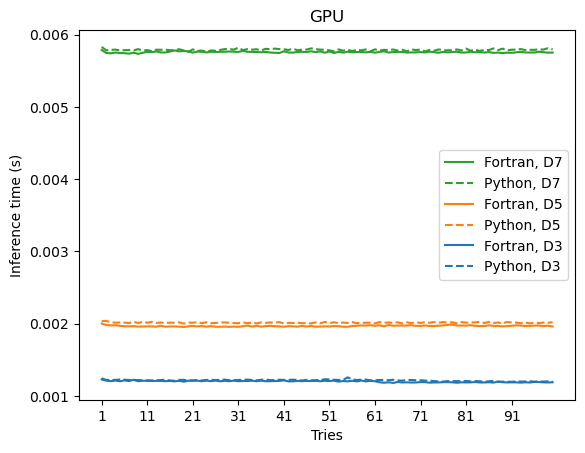

In [5]:
fig, ax = plt.subplots()
ticks_lbl = np.arange(1,101)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels_python = ['Python, D3','Python, D5','Python, D7']
labels_fortran = ['Fortran, D3','Fortran, D5','Fortran, D7']

for i in np.arange(5,step=2):
    ax.plot(ticks_lbl,fdsg[i],color=colors[i//2],linestyle='-',label=labels_fortran[i//2])

for i in np.arange(5,step=2):
    ax.plot(ticks_lbl,pdsg[i],color=colors[i//2],linestyle='--',label=labels_python[i//2])

ax.set_xticks(ticks_lbl[::10])

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order
order = [2,5,1,4,0,3]

# pass handle & labels lists along with order as below
ax.legend([handles[i] for i in order], [labels[i] for i in order])
ax.set_xlabel("Tries")
ax.set_ylabel("Inference time (s)")
ax.set_title("GPU")

plt.savefig('./plots/GPUDs.png')
plt.show()

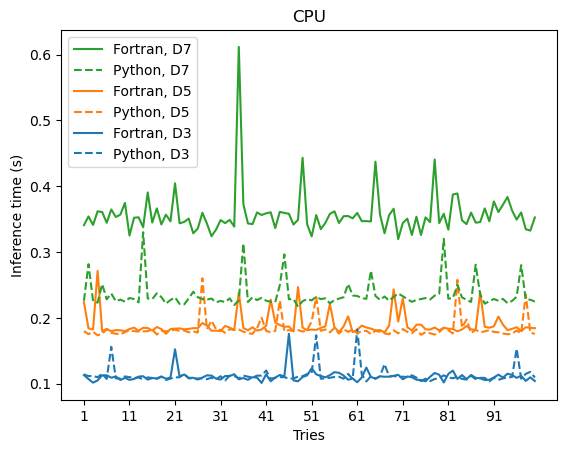

In [8]:
fig, ax = plt.subplots()
ticks_lbl = np.arange(1,101)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels_python = ['Python, D3','Python, D5','Python, D7']
labels_fortran = ['Fortran, D3','Fortran, D5','Fortran, D7']

for i in np.arange(5,step=2):
    ax.plot(ticks_lbl,fdsc[i],color=colors[i//2],linestyle='-',label=labels_fortran[i//2])

for i in np.arange(5,step=2):
    ax.plot(ticks_lbl,pdsc[i],color=colors[i//2],linestyle='--',label=labels_python[i//2])

ax.set_xticks(ticks_lbl[::10])

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order
order = [2,5,1,4,0,3]

# pass handle & labels lists along with order as below
ax.legend([handles[i] for i in order], [labels[i] for i in order])
ax.set_xlabel("Tries")
ax.set_ylabel("Inference time (s)")
ax.set_title("CPU")

plt.savefig('./plots/CPUDs.png')
plt.show()

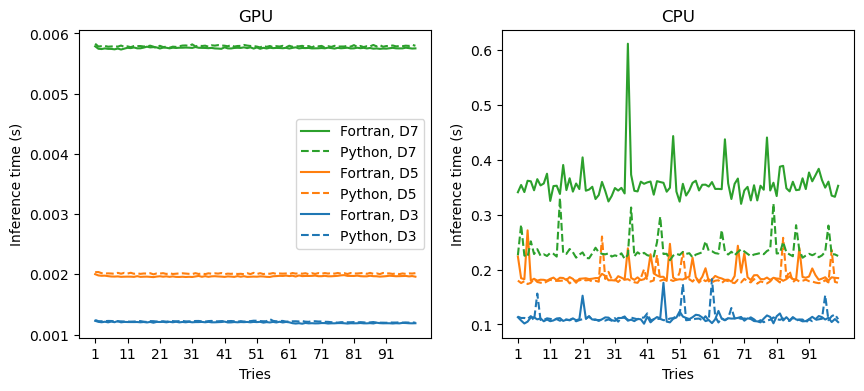

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ticks_lbl = np.arange(1,101)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels_python = ['Python, D3','Python, D5','Python, D7']
labels_fortran = ['Fortran, D3','Fortran, D5','Fortran, D7']

for i in np.arange(5,step=2):
    axs[0].plot(ticks_lbl,fdsg[i],color=colors[i//2],linestyle='-',label=labels_fortran[i//2])

for i in np.arange(5,step=2):
    axs[0].plot(ticks_lbl,pdsg[i],color=colors[i//2],linestyle='--',label=labels_python[i//2])

axs[0].set_xticks(ticks_lbl[::10])

# reordering the labels
handles, labels = axs[0].get_legend_handles_labels()

# specify order
order = [2,5,1,4,0,3]

# pass handle & labels lists along with order as below
axs[0].legend([handles[i] for i in order], [labels[i] for i in order])
axs[0].set_xlabel("Tries")
axs[0].set_ylabel("Inference time (s)")
axs[0].set_title("GPU")

for i in np.arange(5,step=2):
    axs[1].plot(ticks_lbl,fdsc[i],color=colors[i//2],linestyle='-',label=labels_fortran[i//2])

for i in np.arange(5,step=2):
    axs[1].plot(ticks_lbl,pdsc[i],color=colors[i//2],linestyle='--',label=labels_python[i//2])

axs[1].set_xticks(ticks_lbl[::10])

# reordering the labels
handles, labels = axs[1].get_legend_handles_labels()

# pass handle & labels lists along with order as below
#axs[1].legend([handles[i] for i in order], [labels[i] for i in order])
axs[1].set_xlabel("Tries")
axs[1].set_ylabel("Inference time (s)")
axs[1].set_title("CPU")

plt.savefig('./plots/Ds.png')
plt.show()

In [15]:
py_model_g = [0.015996, 0.035567, 0.475929]
py_model_c = [0.005777,  0.027000, 0.434281]
ft_model_g = [3.00655849E-02, 5.82213104E-02, 0.502826869]
ft_model_c = [0.110143363, 0.188515007, 0.523166656]

In [16]:
model_loading_all = np.concat([py_model_g, ft_model_g, py_model_c, ft_model_c])
model_loading_all = np.insert(model_loading_all, 6, 0)
model_loading_all

array([0.015996  , 0.035567  , 0.475929  , 0.03006558, 0.05822131,
       0.50282687, 0.        , 0.005777  , 0.027     , 0.434281  ,
       0.11014336, 0.18851501, 0.52316666])

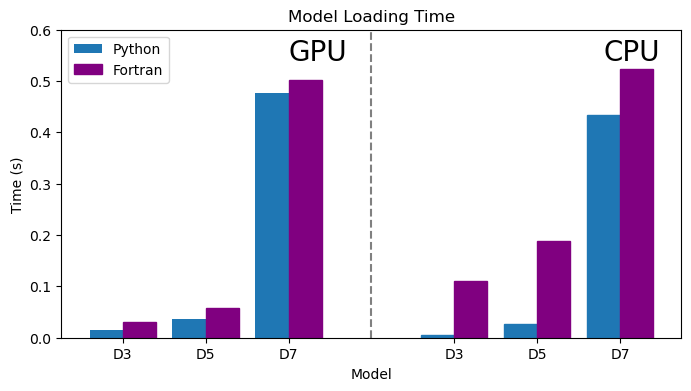

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

#for mode in [p_data_loading_g, f_data_loading_g, p_data_loading_c, f_data_loading_c]:
#    ax.bar([1,2,3,4,5],mode)

gpu_bars = [0,1,2]
barplot_pg = ax.bar([x-0.2 for x in gpu_bars], py_model_g, 0.4)
barplot_fg = ax.bar([x+0.2 for x in gpu_bars], ft_model_g, 0.4)
for i in range(len(barplot_fg)):
    barplot_fg[i].set_color('purple')

cpu_bars = [4,5,6]
barplot_pc = ax.bar([x-0.2 for x in cpu_bars], py_model_c, 0.4)
barplot_fc = ax.bar([x+0.2 for x in cpu_bars], ft_model_c, 0.4)
for i in range(len(barplot_fc)):
    barplot_pc[i].set_color('tab:blue')
    barplot_fc[i].set_color('purple')

ax.legend([barplot_pg[0],barplot_fg[0]],['Python','Fortran'])
ax.set_xticks([0,1,2,4,5,6],['D3','D5','D7','D3','D5','D7'])
ax.vlines(3,0,1,color='gray',ls='--')
ax.set_ylim(0,0.6)
ax.set_xlabel('Model')
ax.set_ylabel('Time (s)')
ax.set_title('Model Loading Time')
ax.text(2,0.54,'GPU',size=20)
ax.text(5.8,0.54,'CPU',size=20)

plt.savefig('./plots/model_time_depths.png')
plt.show()